### Importing Necessary Libraries

In [2]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
# from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [3]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [4]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [5]:
# test_labels = labels.sample(800).sort_values(by='id')
# labels = labels[~labels['id'].isin(list(test_labels['id']))]

In [6]:
# test_labels

In [7]:
# labels

In [8]:
# labels.to_csv('./Data/train_labels_1.csv', index=False)
# test_labels.to_csv('./Data/test_labels_1.csv', index=False)

In [9]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [10]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [11]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [12]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

We have already generated the Extracted Feature Vectors from the ResNet Model now we train using that, so we load those feature vectors.

In [16]:
fine_tune_data = np.load('./Data/ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 5, 2048)

In [17]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [18]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 5, 2048)

In [19]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [20]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 5, 2048)

In [21]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

## Fine-Tuning Models

The fine-tuning part of our model.

In [129]:
def ftmodel():
    inputs = Input(shape=(5, 2048))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.5
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='RestNet-FineTune')
    return model1

In [130]:
model1 = ftmodel()
model1.summary()

Model: "RestNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 2048)]         0         
                                                                 
 flatten_4 (Flatten)         (None, 10240)             0         
                                                                 
 batch_normalization_8 (Batc  (None, 10240)            40960     
 hNormalization)                                                 
                                                                 
 top_dropout_2 (Dropout)     (None, 10240)             0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               5243392   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                  

### Model Training

The fine-tuning will be done on the ResNet's $2048D$ representation vectors.

In [131]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [132]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/ResNet-4P/auto-ResNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [133]:
history = model1.fit(fine_tune_data_train, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/ResNet-4P/effnet-4p-model-weights")
model1.load_weights('./Models/ResNet-4P/effnet-4p-model-weights')

Epoch 1/1000
 1/19 [>.............................] - ETA: 7s - loss: 4.1017 - accuracy: 0.0550

2022-10-08 14:29:05.341901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 2.2952 - accuracy: 0.4243

2022-10-08 14:29:05.895898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 34ms/step - loss: 2.2952 - accuracy: 0.4243 - val_loss: 1.9036 - val_accuracy: 0.4100
Epoch 2/1000
19/19 [==============================] - 0s 24ms/step - loss: 1.5462 - accuracy: 0.5808 - val_loss: 1.6921 - val_accuracy: 0.5375
Epoch 3/1000
19/19 [==============================] - 0s 23ms/step - loss: 1.3098 - accuracy: 0.6321 - val_loss: 1.6123 - val_accuracy: 0.5975
Epoch 4/1000
19/19 [==============================] - 0s 24ms/step - loss: 1.1656 - accuracy: 0.6683 - val_loss: 1.5149 - val_accuracy: 0.6375
Epoch 5/1000
19/19 [==============================] - 0s 24ms/step - loss: 1.0612 - accuracy: 0.6980 - val_loss: 1.4415 - val_accuracy: 0.6562
Epoch 6/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.9670 - accuracy: 0.7219 - val_loss: 1.3902 - val_accuracy: 0.6687
Epoch 7/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.8957 - accuracy: 0.7428 - val_loss: 1.3158 - val_accuracy: 0.6725
Epoch 8/1000

19/19 [==============================] - 0s 14ms/step - loss: 0.1892 - accuracy: 0.9607 - val_loss: 0.8949 - val_accuracy: 0.7662
Epoch 59/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1832 - accuracy: 0.9647 - val_loss: 0.8918 - val_accuracy: 0.7713
Epoch 60/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.1794 - accuracy: 0.9645 - val_loss: 0.8935 - val_accuracy: 0.7750
Epoch 61/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1815 - accuracy: 0.9640 - val_loss: 0.9018 - val_accuracy: 0.7688
Epoch 62/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.1725 - accuracy: 0.9686 - val_loss: 0.8961 - val_accuracy: 0.7812
Epoch 63/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1746 - accuracy: 0.9668 - val_loss: 0.8974 - val_accuracy: 0.7700
Epoch 64/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.1717 - accuracy: 0.9674 - val_loss: 0.9033 - val_accuracy: 0.7637
Epoch 

Epoch 115/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1125 - accuracy: 0.9868 - val_loss: 0.9431 - val_accuracy: 0.7837
Epoch 116/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1128 - accuracy: 0.9859 - val_loss: 0.9436 - val_accuracy: 0.7900
Epoch 117/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1126 - accuracy: 0.9853 - val_loss: 0.9472 - val_accuracy: 0.7775
Epoch 118/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1124 - accuracy: 0.9862 - val_loss: 0.9542 - val_accuracy: 0.7825
Epoch 119/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1122 - accuracy: 0.9859 - val_loss: 0.9445 - val_accuracy: 0.7975
Epoch 120/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.1115 - accuracy: 0.9863 - val_loss: 0.9754 - val_accuracy: 0.7825
Epoch 121/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1136 - accuracy: 0.9845 - val_loss: 0.9583 - val_ac

19/19 [==============================] - 0s 14ms/step - loss: 0.1011 - accuracy: 0.9895 - val_loss: 1.0097 - val_accuracy: 0.7837
Epoch 172/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1010 - accuracy: 0.9905 - val_loss: 1.0226 - val_accuracy: 0.7812
Epoch 173/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0992 - accuracy: 0.9907 - val_loss: 0.9951 - val_accuracy: 0.7900
Epoch 174/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.0961 - accuracy: 0.9911 - val_loss: 0.9836 - val_accuracy: 0.7850
Epoch 175/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0989 - accuracy: 0.9903 - val_loss: 1.0008 - val_accuracy: 0.7775
Epoch 176/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1006 - accuracy: 0.9887 - val_loss: 0.9817 - val_accuracy: 0.7837
Epoch 177/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1025 - accuracy: 0.9893 - val_loss: 0.9748 - val_accuracy: 0.7837


19/19 [==============================] - 0s 13ms/step - loss: 0.0980 - accuracy: 0.9914 - val_loss: 0.9953 - val_accuracy: 0.7987
Epoch 228/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0976 - accuracy: 0.9907 - val_loss: 1.0317 - val_accuracy: 0.7975
Epoch 229/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0959 - accuracy: 0.9914 - val_loss: 1.0291 - val_accuracy: 0.7850
Epoch 230/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0964 - accuracy: 0.9907 - val_loss: 1.0168 - val_accuracy: 0.7887
Epoch 231/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0964 - accuracy: 0.9916 - val_loss: 1.0201 - val_accuracy: 0.7925
Epoch 232/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0961 - accuracy: 0.9911 - val_loss: 1.0169 - val_accuracy: 0.7825
Epoch 233/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0986 - accuracy: 0.9914 - val_loss: 1.0091 - val_accuracy: 0.7900


19/19 [==============================] - 0s 14ms/step - loss: 0.0958 - accuracy: 0.9928 - val_loss: 1.1056 - val_accuracy: 0.7763
Epoch 284/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0943 - accuracy: 0.9932 - val_loss: 1.0863 - val_accuracy: 0.7862
Epoch 285/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0932 - accuracy: 0.9938 - val_loss: 1.0809 - val_accuracy: 0.7837
Epoch 286/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0963 - accuracy: 0.9920 - val_loss: 1.1130 - val_accuracy: 0.7788
Epoch 287/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0957 - accuracy: 0.9916 - val_loss: 1.1087 - val_accuracy: 0.7775
Epoch 288/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0962 - accuracy: 0.9926 - val_loss: 1.0801 - val_accuracy: 0.7763
Epoch 289/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0996 - accuracy: 0.9905 - val_loss: 1.0871 - val_accuracy: 0.7775


19/19 [==============================] - 0s 14ms/step - loss: 0.0984 - accuracy: 0.9916 - val_loss: 1.1219 - val_accuracy: 0.7825
Epoch 340/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0962 - accuracy: 0.9918 - val_loss: 1.1013 - val_accuracy: 0.7812
Epoch 341/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0959 - accuracy: 0.9932 - val_loss: 1.1051 - val_accuracy: 0.7837
Epoch 342/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0949 - accuracy: 0.9926 - val_loss: 1.1023 - val_accuracy: 0.7812
Epoch 343/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0935 - accuracy: 0.9936 - val_loss: 1.1147 - val_accuracy: 0.7713
Epoch 344/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0958 - accuracy: 0.9928 - val_loss: 1.1125 - val_accuracy: 0.7725
Epoch 345/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0945 - accuracy: 0.9938 - val_loss: 1.1081 - val_accuracy: 0.7763


19/19 [==============================] - 0s 14ms/step - loss: 0.0963 - accuracy: 0.9934 - val_loss: 1.1474 - val_accuracy: 0.7675
Epoch 396/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0967 - accuracy: 0.9919 - val_loss: 1.1528 - val_accuracy: 0.7887
Epoch 397/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0936 - accuracy: 0.9939 - val_loss: 1.1704 - val_accuracy: 0.7763
Epoch 398/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0951 - accuracy: 0.9935 - val_loss: 1.1890 - val_accuracy: 0.7800
Epoch 399/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0971 - accuracy: 0.9932 - val_loss: 1.1823 - val_accuracy: 0.7738
Epoch 400/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0962 - accuracy: 0.9927 - val_loss: 1.1571 - val_accuracy: 0.7713
Epoch 401/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0957 - accuracy: 0.9940 - val_loss: 1.1777 - val_accuracy: 0.7725


19/19 [==============================] - 0s 14ms/step - loss: 0.0988 - accuracy: 0.9927 - val_loss: 1.1249 - val_accuracy: 0.7812
Epoch 452/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0969 - accuracy: 0.9937 - val_loss: 1.1298 - val_accuracy: 0.7812
Epoch 453/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0978 - accuracy: 0.9933 - val_loss: 1.1452 - val_accuracy: 0.7738
Epoch 454/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0969 - accuracy: 0.9934 - val_loss: 1.1417 - val_accuracy: 0.7788
Epoch 455/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0953 - accuracy: 0.9949 - val_loss: 1.1387 - val_accuracy: 0.7725
Epoch 456/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0960 - accuracy: 0.9939 - val_loss: 1.1607 - val_accuracy: 0.7713
Epoch 457/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0958 - accuracy: 0.9942 - val_loss: 1.1622 - val_accuracy: 0.7800


19/19 [==============================] - 0s 14ms/step - loss: 0.0970 - accuracy: 0.9934 - val_loss: 1.1618 - val_accuracy: 0.7738
Epoch 508/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0956 - accuracy: 0.9945 - val_loss: 1.1676 - val_accuracy: 0.7775
Epoch 509/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0979 - accuracy: 0.9936 - val_loss: 1.1769 - val_accuracy: 0.7788
Epoch 510/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0969 - accuracy: 0.9934 - val_loss: 1.1585 - val_accuracy: 0.7850
Epoch 511/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0981 - accuracy: 0.9936 - val_loss: 1.1866 - val_accuracy: 0.7788
Epoch 512/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0997 - accuracy: 0.9936 - val_loss: 1.1886 - val_accuracy: 0.7725
Epoch 513/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0949 - accuracy: 0.9942 - val_loss: 1.1841 - val_accuracy: 0.7700


19/19 [==============================] - 0s 14ms/step - loss: 0.0975 - accuracy: 0.9939 - val_loss: 1.1618 - val_accuracy: 0.7713
Epoch 564/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0956 - accuracy: 0.9935 - val_loss: 1.2014 - val_accuracy: 0.7725
Epoch 565/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0986 - accuracy: 0.9925 - val_loss: 1.1540 - val_accuracy: 0.7750
Epoch 566/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0970 - accuracy: 0.9938 - val_loss: 1.1635 - val_accuracy: 0.7775
Epoch 567/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0982 - accuracy: 0.9934 - val_loss: 1.1684 - val_accuracy: 0.7750
Epoch 568/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0974 - accuracy: 0.9933 - val_loss: 1.1555 - val_accuracy: 0.7725
Epoch 569/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0987 - accuracy: 0.9939 - val_loss: 1.1530 - val_accuracy: 0.7763


19/19 [==============================] - 0s 14ms/step - loss: 0.0954 - accuracy: 0.9944 - val_loss: 1.1887 - val_accuracy: 0.7750
Epoch 620/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0938 - accuracy: 0.9951 - val_loss: 1.1842 - val_accuracy: 0.7725
Epoch 621/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0931 - accuracy: 0.9949 - val_loss: 1.1739 - val_accuracy: 0.7800
Epoch 622/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1002 - accuracy: 0.9924 - val_loss: 1.1648 - val_accuracy: 0.7763
Epoch 623/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0970 - accuracy: 0.9935 - val_loss: 1.1332 - val_accuracy: 0.7825
Epoch 624/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0972 - accuracy: 0.9940 - val_loss: 1.1227 - val_accuracy: 0.7825
Epoch 625/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0963 - accuracy: 0.9939 - val_loss: 1.1299 - val_accuracy: 0.7825


19/19 [==============================] - 0s 14ms/step - loss: 0.0988 - accuracy: 0.9938 - val_loss: 1.1800 - val_accuracy: 0.7812
Epoch 676/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0974 - accuracy: 0.9944 - val_loss: 1.1542 - val_accuracy: 0.7825
Epoch 677/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0946 - accuracy: 0.9953 - val_loss: 1.1485 - val_accuracy: 0.7837
Epoch 678/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0970 - accuracy: 0.9938 - val_loss: 1.1247 - val_accuracy: 0.7775
Epoch 679/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0979 - accuracy: 0.9939 - val_loss: 1.1412 - val_accuracy: 0.7800
Epoch 680/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0970 - accuracy: 0.9947 - val_loss: 1.1531 - val_accuracy: 0.7812
Epoch 681/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0980 - accuracy: 0.9938 - val_loss: 1.1618 - val_accuracy: 0.7788


19/19 [==============================] - 0s 14ms/step - loss: 0.0956 - accuracy: 0.9950 - val_loss: 1.1961 - val_accuracy: 0.7763
Epoch 732/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0946 - accuracy: 0.9949 - val_loss: 1.1689 - val_accuracy: 0.7800
Epoch 733/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0935 - accuracy: 0.9960 - val_loss: 1.1690 - val_accuracy: 0.7788
Epoch 734/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0956 - accuracy: 0.9944 - val_loss: 1.1864 - val_accuracy: 0.7812
Epoch 735/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0983 - accuracy: 0.9936 - val_loss: 1.1697 - val_accuracy: 0.7800
Epoch 736/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0949 - accuracy: 0.9945 - val_loss: 1.1771 - val_accuracy: 0.7788
Epoch 737/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0966 - accuracy: 0.9943 - val_loss: 1.2149 - val_accuracy: 0.7738


19/19 [==============================] - 0s 13ms/step - loss: 0.0966 - accuracy: 0.9941 - val_loss: 1.1885 - val_accuracy: 0.7788
Epoch 788/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0982 - accuracy: 0.9939 - val_loss: 1.1829 - val_accuracy: 0.7775
Epoch 789/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0960 - accuracy: 0.9946 - val_loss: 1.1639 - val_accuracy: 0.7850
Epoch 790/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0959 - accuracy: 0.9947 - val_loss: 1.1527 - val_accuracy: 0.7900
Epoch 791/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0968 - accuracy: 0.9941 - val_loss: 1.1576 - val_accuracy: 0.7862
Epoch 792/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0968 - accuracy: 0.9942 - val_loss: 1.1498 - val_accuracy: 0.7775
Epoch 793/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0980 - accuracy: 0.9942 - val_loss: 1.1610 - val_accuracy: 0.7862


19/19 [==============================] - 0s 14ms/step - loss: 0.0967 - accuracy: 0.9940 - val_loss: 1.1703 - val_accuracy: 0.7862
Epoch 844/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0942 - accuracy: 0.9955 - val_loss: 1.1821 - val_accuracy: 0.7812
Epoch 845/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0976 - accuracy: 0.9943 - val_loss: 1.2065 - val_accuracy: 0.7750
Epoch 846/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0978 - accuracy: 0.9941 - val_loss: 1.2083 - val_accuracy: 0.7800
Epoch 847/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0973 - accuracy: 0.9937 - val_loss: 1.1896 - val_accuracy: 0.7713
Epoch 848/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0989 - accuracy: 0.9938 - val_loss: 1.1759 - val_accuracy: 0.7862
Epoch 849/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0989 - accuracy: 0.9936 - val_loss: 1.1771 - val_accuracy: 0.7725


19/19 [==============================] - 0s 14ms/step - loss: 0.0945 - accuracy: 0.9955 - val_loss: 1.2440 - val_accuracy: 0.7788
Epoch 900/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0961 - accuracy: 0.9942 - val_loss: 1.2336 - val_accuracy: 0.7862
Epoch 901/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0947 - accuracy: 0.9953 - val_loss: 1.2427 - val_accuracy: 0.7775
Epoch 902/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0976 - accuracy: 0.9941 - val_loss: 1.2358 - val_accuracy: 0.7738
Epoch 903/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0983 - accuracy: 0.9934 - val_loss: 1.2430 - val_accuracy: 0.7763
Epoch 904/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0958 - accuracy: 0.9947 - val_loss: 1.2233 - val_accuracy: 0.7862
Epoch 905/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0972 - accuracy: 0.9941 - val_loss: 1.2143 - val_accuracy: 0.7875


19/19 [==============================] - 0s 13ms/step - loss: 0.0952 - accuracy: 0.9948 - val_loss: 1.2011 - val_accuracy: 0.7837
Epoch 956/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0969 - accuracy: 0.9938 - val_loss: 1.1975 - val_accuracy: 0.7962
Epoch 957/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0978 - accuracy: 0.9938 - val_loss: 1.1942 - val_accuracy: 0.8012
Epoch 958/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0964 - accuracy: 0.9943 - val_loss: 1.2067 - val_accuracy: 0.7975
Epoch 959/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0978 - accuracy: 0.9936 - val_loss: 1.1874 - val_accuracy: 0.8012
Epoch 960/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0958 - accuracy: 0.9948 - val_loss: 1.1829 - val_accuracy: 0.7912
Epoch 961/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0951 - accuracy: 0.9944 - val_loss: 1.2014 - val_accuracy: 0.7962


In [134]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

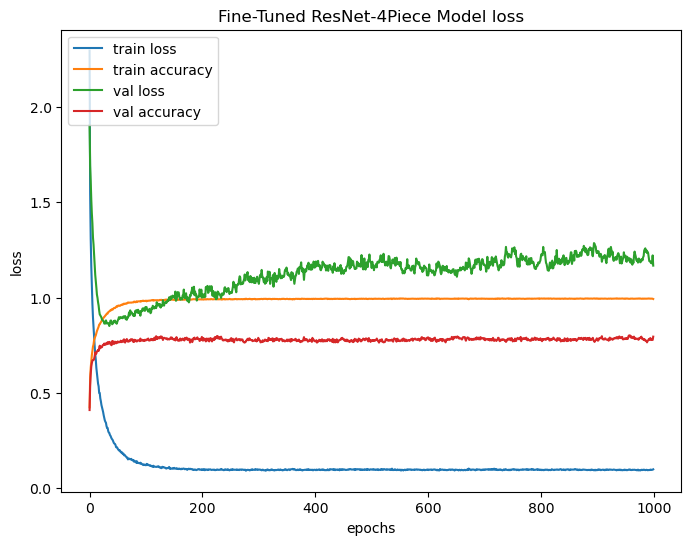

In [135]:
plot_train_loss(history, 'Fine-Tuned ResNet-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [136]:
train_preds = model1.predict(fine_tune_data_train)

 61/475 [==>...........................] - ETA: 1s

2022-10-08 14:34:57.061585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 2s 3ms/step


In [137]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [138]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [139]:
np.sum(train_pred_labels == train_labels['label'])

15197

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [140]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
3597,3781,./Data/train/train/3781.tif,0
12255,12896,./Data/train/train/12896.tif,9
14569,15333,./Data/train/train/15333.tif,7


In [141]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,1.000000,0.998978,0.999488,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [142]:
test_preds = model1.predict(fine_tune_data_test)

25/25 [==============================] - 0s 4ms/step


In [143]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [144]:
test_pred_labels

array([11,  8,  6,  1,  1,  9, 13, 12, 14,  1,  6, 15,  7, 14, 13, 11,  0,
        9,  6,  1,  8, 14,  3, 12,  6,  0,  3, 12,  3,  3, 11,  1,  9,  2,
        1,  8,  4,  7, 11,  9,  6, 12, 14,  2,  5, 14,  3,  0, 13,  4,  0,
       10, 12,  0,  1, 14, 10,  6,  9,  2, 15, 13, 11, 11,  3, 10,  8,  0,
        6,  3,  4,  4, 12,  0,  8,  6,  7,  0, 12, 11, 11,  9, 12, 12,  9,
        8,  1, 13, 13,  1, 10, 11,  4, 10,  1, 10, 11,  8, 13, 10,  3, 10,
       12,  9,  7, 14,  8,  2,  1,  8,  7,  5,  9,  4, 12,  5, 12,  1, 11,
        6, 13,  1,  0, 12,  1,  5, 10, 13,  0, 11,  3, 11,  6,  1,  6,  9,
       14, 10,  7, 14, 10,  8,  4, 12,  8,  5,  8,  9,  2, 13, 15, 14,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4, 10,  5,  8, 15,  3,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 11, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13, 13, 10, 11, 11, 15,  1,  9,  1,
        9, 11, 13, 14, 12,  1,  4,  8, 10,  6, 13,  5,  4, 12,  8,  0,  9,
       13, 15,  1,  7, 10

In [145]:
np.sum(test_pred_labels == test_labels['label'])

636

In [146]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
4,65,./Data/train/train/65.tif,14
7,100,./Data/train/train/100.tif,10
14,203,./Data/train/train/203.tif,1
19,372,./Data/train/train/372.tif,13
20,378,./Data/train/train/378.tif,12
...,...,...,...
779,15568,./Data/train/train/15568.tif,9
780,15571,./Data/train/train/15571.tif,14
782,15582,./Data/train/train/15582.tif,3
788,15687,./Data/train/train/15687.tif,12


In [147]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.754386,0.796296,0.774775,54
1,0.543860,0.704545,0.613861,44
2,0.947368,0.837209,0.888889,43
3,0.851064,0.869565,0.860215,46
4,0.853659,0.972222,0.909091,36
5,0.750000,0.600000,0.666667,50
6,0.952381,0.869565,0.909091,46
7,0.843137,0.826923,0.834951,52
8,0.838710,0.962963,0.896552,54
9,0.854167,0.872340,0.863158,47


In [148]:
np.mean(fscore)

0.7973631449848214

#### On Validation Data

Generating Predictions for the Validation Set

In [149]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [150]:
fine_tune_data_validation = np.load('./Data/ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation.shape

(900, 5, 2048)

In [151]:
valid_preds = model1.predict(fine_tune_data_validation)

29/29 [==============================] - 0s 3ms/step


2022-10-08 14:36:16.133452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [152]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [153]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,13
896,18697,12
897,18698,8
898,18699,5


In [154]:
submission_data.to_csv('./Submissions/submission-resnet-4p.csv', index=False)